# Time series analysis with ARIMA
Some time ago I had a discussion about time series analysis and ARIMA models, which found me quite unprepared!
So I decided to look a bit closer to this neat piece of classical time series analysis. I found out that there are several excellent tutorials on how to use ARIMA, which I link below. Still, I found it useful to compile my own example to summarize my understanding of the problem and to collect links to useful resources.

## Import libraries and get sample data

In [6]:
# Import libraries
import warnings
import itertools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

# Defaults
plt.rcParams['figure.figsize'] = (20.0, 10.0)
plt.rcParams.update({'font.size': 12})
plt.style.use('ggplot')

In [1]:
print("helloworld")

helloworld


Get the classic international airline passengers data, downloadable from the DataMarket webpage (https://datamarket.com/data/set/22u3/international-airline-passengers-monthly-totals-in-thousands-jan-49-dec-60#!ds=22u3&display=line) as a CSV with filename "international-airline-passengers.csv".

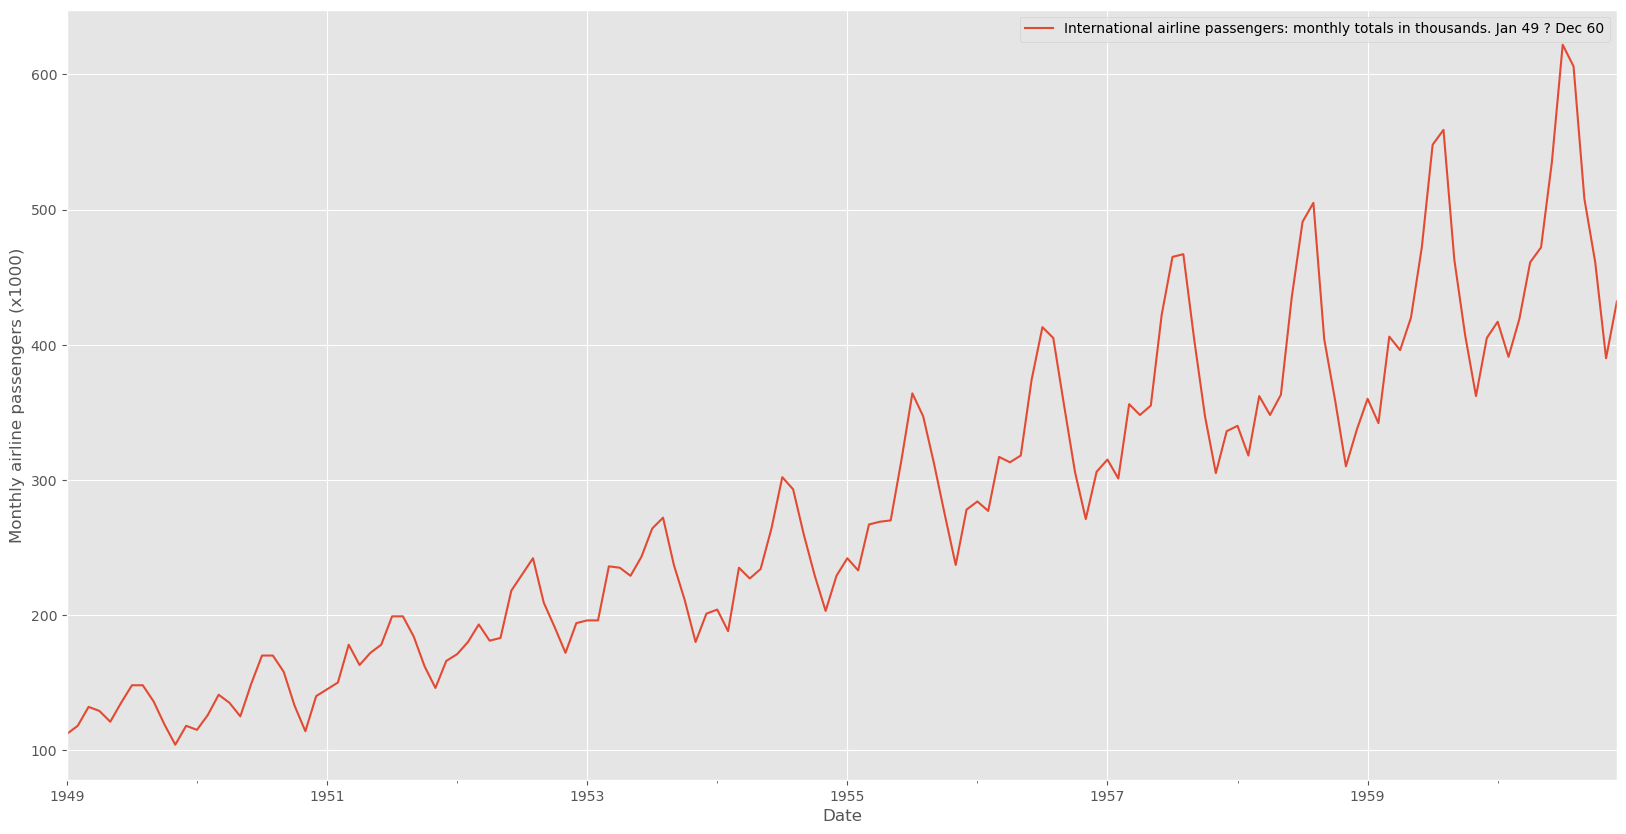

In [7]:
# Load the data
data = pd.read_csv('international-airline-passengers.csv', engine='python', skipfooter=3)
# A bit of pre-processing to make it nicer
data['Month']=pd.to_datetime(data['Month'], format='%Y-%m')
data.set_index(['Month'], inplace=True)

# Plot the data
data.plot()
plt.ylabel('Monthly airline passengers (x1000)')
plt.xlabel('Date')
plt.show()

Two obvious patterns appear in the data, an overall increase in the number of passengers over time, and a 12 months seasonality with peaks corresponding to the northern emisphere summer period.

## ARIMA
ARIMA stands for Auto-Regressive Integrated Moving Average. There are three  integers (p, d, q) that are used to parametrize ARIMA models. Because of that, a nonseasonal ARIMA model is denoted with ARIMA(p, d, q): 
<ul>
<li><strong>p</strong> is the number of autoregressive terms (AR part). It allows to incorporate the effect of past values into our model. Intuitively, this would be similar to stating that it is likely to be warm tomorrow if it has been warm the past 3 days.</li>
<li><strong>d</strong> is the number of nonseasonal differences needed for stationarity. Intuitively, this would be similar to stating that it is likely to be same temperature tomorrow if the difference in temperature in the last three days has been very small.</li>
<li><strong>q</strong> is the number of lagged forecast errors in the prediction equation (MA part). This allows us to set the error of our model as a linear combination of the error values observed at previous time points in the past.</li>
</ul>

When dealing with seasonal effects, as in our example, seasonal ARIMA is used, which is denoted as ARIMA(p,d,q)(P,D,Q)s. Here, (p, d, q) are the nonseasonal parameters described above, (<strong>P, D, Q</strong>) follow the same definition but are applied to the seasonal component of the time series. The term <strong>s</strong> is the periodicity of the time series.

While in this case it is clear that s=12, how do we set the other parameters? 

It is pretty much based on experience. There are numerous best practices that can be followed to identify ARIMA models, such as: 
http://people.duke.edu/~rnau/arimrule.htm.

Here we use grid search over all possible combinations of parameter values within a predefined range of values (heavily inspired by https://www.digitalocean.com/community/tutorials/a-guide-to-time-series-forecasting-with-arima-in-python-3). 

$statsmodels.tsa.statespace.sarimax.SARIMAXResults$ returns values for AIC (Akaike Information Criterion) and BIC (Bayes Information Criterion) that can be minimized to select the best fitting model. We use the AIC value, which estimates the information lost when a given model is used to represent the process that generates the data. In doing so, it deals with the trade-off between the goodness of fit of the model and the complexity of the model itself.

In [8]:
# Define the d and q parameters to take any value between 0 and 1
q = d = range(0, 2)
# Define the p parameters to take any value between 0 and 3
p = range(0, 4)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


We select a subset of the data series as training data, say the first 11 years. Our goal is to predict the last year of the series based on this input.

In [9]:
train_data = data['1949-01-01':'1959-12-01']
test_data = data['1960-01-01':'1960-12-01']

In [10]:
warnings.filterwarnings("ignore") # specify to ignore warning messages

AIC = []
SARIMAX_model = []
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(train_data,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()

            print('SARIMAX{}x{} - AIC:{}'.format(param, param_seasonal, results.aic), end='\r')
            AIC.append(results.aic)
            SARIMAX_model.append([param, param_seasonal])
        except:
            continue

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.01466D+00    |proj g|=  2.25681D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      1      2      1     0     0   2.206D-06   7.015D+00
  F =   7.0146482280460800     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE, 12) - AIC:1853.867132204165

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bound

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.


At iterate   15    f=  3.79549D+00    |proj g|=  7.21776D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     17     21      1     0     0   1.541D-04   3.795D+00
  F =   3.7954857573957224     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE, 12) - AIC:1008.0082399524707

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.76966D+00    |proj g|=  7.35061D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnin

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate    5    f=  3.48176D+00    |proj g|=  1.05552D-02

At iterate   10    f=  3.48174D+00    |proj g|=  6.18797D-02

At iterate   15    f=  3.48009D+00    |proj g|=  1.66497D+00

At iterate   20    f=  3.46658D+00    |proj g|=  1.63856D+00

At iterate   25    f=  3.46443D+00    |proj g|=  5.69923D-01

At iterate   30    f=  3.46426D+00    |proj g|=  1.25540D-02

At iterate   35    f=  3.46373D+00    |proj g|=  4.15613D-01

At iterate   40    f=  3.45595D+00    |proj g|=  5.54460D-01

At iterate   45    f=  3.45345D+00    |proj g|=  3.41328D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     47     96   


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  3.17135D+00    |proj g|=  3.18113D-01

At iterate   10    f=  3.16116D+00    |proj g|=  6.08249D-02

At iterate   15    f=  3.11289D+00    |proj g|=  8.21219D-02

At iterate   20    f=  3.11256D+00    |proj g|=  1.10049D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     21     27      1     0     0   3.035D-05   3.113D+00
  F =   3.1125636834492658     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE, 12) - AIC:829.7168124306062

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are e

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


RUNNING THE L-BFGS-B CODE, 12) - AIC:823.5135507691755

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.08427D+00    |proj g|=  5.85480D-02

At iterate    5    f=  3.07741D+00    |proj g|=  6.36793D-02


 This problem is unconstrained.



At iterate   10    f=  3.07044D+00    |proj g|=  1.65698D+00

At iterate   15    f=  3.06219D+00    |proj g|=  1.99241D-02

At iterate   20    f=  3.06002D+00    |proj g|=  1.80120D-02

At iterate   25    f=  3.06001D+00    |proj g|=  8.25372D-02

At iterate   30    f=  3.05902D+00    |proj g|=  1.03692D+00

At iterate   35    f=  3.05693D+00    |proj g|=  4.45776D-02

At iterate   40    f=  3.05643D+00    |proj g|=  1.44656D-01



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate   45    f=  3.05627D+00    |proj g|=  1.05950D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     45     69      1     0     0   1.059D-02   3.056D+00
  F =   3.0562688355289866     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE, 12) - AIC:816.8549725796524

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.83904D+00    |proj g|=  9.31664D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnin

 This problem is unconstrained.



At iterate    5    f=  2.77951D+00    |proj g|=  1.27003D-01

At iterate   10    f=  2.77047D+00    |proj g|=  6.51291D-02

At iterate   15    f=  2.76711D+00    |proj g|=  1.66902D-02

At iterate   20    f=  2.74576D+00    |proj g|=  2.23983D-01

At iterate   25    f=  2.73132D+00    |proj g|=  3.09974D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     27     35      1     0     0   3.767D-05   2.731D+00
  F =   2.7313227573632037     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE, 12) - AIC:731.0692079438858

           * * *

Machine precision = 2.220D-16
 N =     

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  4.09393D+00    |proj g|=  1.15313D-01

At iterate   10    f=  4.04545D+00    |proj g|=  9.55784D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     13     22      1     0     0   1.348D-06   4.045D+00
  F =   4.0454046816654072     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE, 12) - AIC:1071.9868359596676

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.78274D+00    |proj g|=  2.54736D-01

At iterate    5    f=  3.72390D+00    |

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   15    f=  5.32547D+00    |proj g|=  9.20993D+00

At iterate   20    f=  3.63179D+00    |proj g|=  3.03553D-01

At iterate   25    f=  3.54261D+00    |proj g|=  1.96405D-01

At iterate   30    f=  3.53975D+00    |proj g|=  9.40453D-02

At iterate   35    f=  3.53780D+00    |proj g|=  1.46292D-03

At iterate   40    f=  3.53778D+00    |proj g|=  4.28320D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     40     69      1     0     0   4.283D-06   3.538D+00
  F =   3.5377825805693810     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE, 12) - AIC:941.9746012703

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   20    f=  3.29128D+00    |proj g|=  4.98614D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     20     26      1     0     0   4.986D-06   3.291D+00
  F =   3.2912789667687470     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE, 12) - AIC:876.8976472269492

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.51949D+00    |proj g|=  6.72051D-01

At iterate    5    f=  5.37369D+00    |proj g|=  4.76442D-02

At iterate   10    f=  5.16896D+00    |p

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.52018D+00    |proj g|=  6.70811D-01

At iterate    5    f=  5.37652D+00    |proj g|=  3.25213D-03

At iterate   10    f=  5.36974D+00    |proj g|=  7.08776D-02

At iterate   15    f=  5.10178D+00    |proj g|=  3.77404D-01

At iterate   20    f=  4.50836D+00    |proj g|=  8.83369D-02

At iterate   25    f=  4.12324D+00    |proj g|=  4.08248D+00

At iterate   30    f=  3.53381D+00    |proj g|=  5.99745D-01

At iterate   35    f=  3.26851D+00    |proj g|=  9.24973D-02

At iterate   40    f=  3.25511D+00    |proj g|=  8.38516D-01

At iterate   45    f=  3.25078D+00    |proj g|=  5.47092D-02

At iterate   50    f=  3.25077D+00    |proj g|=  6.48571D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE, 12) - AIC:818.5774222837408

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.32963D+00    |proj g|=  9.59818D-02

At iterate    5    f=  3.31462D+00    |proj g|=  2.79101D-02

At iterate   10    f=  3.26571D+00    |proj g|=  7.25844D-02

At iterate   15    f=  3.00341D+00    |proj g|=  7.63993D-01

At iterate   20    f=  2.97117D+00    |proj g|=  1.25048D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     24     38      1     0     0   5.864D-05   2.971D+00
  F =   2.9

 This problem is unconstrained.



           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.90665D+00    |proj g|=  5.96002D-01

At iterate    5    f=  4.77857D+00    |proj g|=  2.29273D-02

At iterate   10    f=  4.75588D+00    |proj g|=  1.79674D-01

At iterate   15    f=  4.53903D+00    |proj g|=  1.49974D-01

At iterate   20    f=  4.21518D+00    |proj g|=  1.59116D+00

At iterate   25    f=  3.03717D+00    |proj g|=  4.08424D+00

At iterate   30    f=  2.90495D+00    |proj g|=  9.53264D-02

At iterate   35    f=  2.90075D+00    |proj g|=  2.69307D-02

At iterate   40    f=  2.89998D+00    |proj g|=  1.33213D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projec

 This problem is unconstrained.



At iterate    5    f=  4.77912D+00    |proj g|=  3.69382D-03

At iterate   10    f=  4.76272D+00    |proj g|=  7.29964D-02

At iterate   15    f=  4.73058D+00    |proj g|=  4.75146D-02

At iterate   20    f=  4.40977D+00    |proj g|=  1.56439D+00

At iterate   25    f=  3.62923D+00    |proj g|=  3.43574D-01

At iterate   30    f=  3.10897D+00    |proj g|=  1.61372D+00

At iterate   35    f=  2.91492D+00    |proj g|=  6.06801D-02

At iterate   40    f=  2.88986D+00    |proj g|=  7.37966D-01

At iterate   45    f=  2.88014D+00    |proj g|=  1.93382D-01

At iterate   50    f=  2.87753D+00    |proj g|=  1.34503D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate   10    f=  2.67088D+00    |proj g|=  1.43832D-01

At iterate   15    f=  2.66174D+00    |proj g|=  8.58211D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     17     22      1     0     0   9.293D-06   2.662D+00
  F =   2.6617371884525536     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE, 12) - AIC:712.6986177514741

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.90657D+00    |proj g|=  4.49558D-02

At iterate    5    f=  2.89459D+00    |p

 This problem is unconstrained.



At iterate   10    f=  2.81636D+00    |proj g|=  8.95841D-02

At iterate   15    f=  2.60369D+00    |proj g|=  1.54755D-01

At iterate   20    f=  2.58468D+00    |proj g|=  5.34367D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     24     33      1     0     0   2.680D-05   2.584D+00
  F =   2.5843028956996918     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE, 12) - AIC:694.2559644647187

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.79358D+00    |p

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.32346D+00    |proj g|=  7.99564D-02

At iterate    5    f=  3.32279D+00    |proj g|=  4.06423D-02

At iterate   10    f=  3.31993D+00    |proj g|=  1.54488D-01

At iterate   15    f=  3.31923D+00    |proj g|=  6.25220D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     15     17      1     0     0   6.252D-06   3.319D+00
  F =   3.3192336384675927     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING 

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   15    f=  3.04437D+00    |proj g|=  4.72566D-02

At iterate   20    f=  3.04424D+00    |proj g|=  1.30092D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     23     29      1     0     0   5.000D-06   3.044D+00
  F =   3.0442428135706665     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE, 12) - AIC:811.6801027826559

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.76398D+00    |proj g|=  3.33635D-06

           * * *

Tit   = total number o

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  2.75549D+00    |proj g|=  8.13483D-02

At iterate   10    f=  2.75093D+00    |proj g|=  3.84471D-03

At iterate   15    f=  2.75025D+00    |proj g|=  4.48037D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     18     25      1     0     0   1.305D-06   2.750D+00
  F =   2.7502395471927765     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE, 12) - AIC:734.063240458893

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.70843D+00    |pr

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  2.70997D+00    |proj g|=  4.25756D-02

At iterate   10    f=  2.70966D+00    |proj g|=  1.16751D-03

At iterate   15    f=  2.70964D+00    |proj g|=  1.64589D-02

At iterate   20    f=  2.70556D+00    |proj g|=  6.87446D-02

At iterate   25    f=  2.70476D+00    |proj g|=  1.82681D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     26     35      1     0     0   2.429D-07   2.705D+00
  F =   2.7047574537860570     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE, 12) - AIC:724.0559677995191

           * * *

Machine precision = 2.220D-16
 N =     

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  2.41204D+00    |proj g|=  3.17053D-03

At iterate   10    f=  2.41178D+00    |proj g|=  7.94192D-03

At iterate   15    f=  2.41178D+00    |proj g|=  5.02052D-03

At iterate   20    f=  2.41178D+00    |proj g|=  2.11396D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     21     37      1     0     0   2.114D-04   2.412D+00
  F =   2.4117781993120468     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE, 12) - AIC:1245.6319844870777

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are 

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  3.94424D+00    |proj g|=  4.68212D-02

At iterate   10    f=  3.44060D+00    |proj g|=  7.75066D-01

At iterate   15    f=  3.35942D+00    |proj g|=  1.69201D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     18     24      1     0     0   3.588D-06   3.359D+00
  F =   3.3594221231066292     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE, 12) - AIC:892.8874405001501

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.91508D+00    |p

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE, 12) - AIC:802.8580194674369

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.58010D+00    |proj g|=  9.93621D-02

At iterate    5    f=  3.54760D+00    |proj g|=  2.40852D-02

At iterate   10    f=  3.30058D+00    |proj g|=  1.26696D-01

At iterate   15    f=  2.99774D+00    |proj g|=  6.76644D-02

At iterate   20    f=  2.99717D+00    |proj g|=  1.17112D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     20     30      1     0     0   1.171D-05   2.997D+00
  F =   2.9

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   20    f=  3.01124D+00    |proj g|=  1.53106D-02

At iterate   25    f=  3.00721D+00    |proj g|=  8.27580D-03

At iterate   30    f=  3.00471D+00    |proj g|=  2.30785D-02

At iterate   35    f=  3.00275D+00    |proj g|=  1.77248D-02

At iterate   40    f=  3.00166D+00    |proj g|=  1.63607D-02

At iterate   45    f=  3.00074D+00    |proj g|=  3.16759D-02

At iterate   50    f=  3.00002D+00    |proj g|=  1.68827D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     50     68      1     0     0   1.688D-02   3.000D+00
  F =   3.0000198193084975     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT       

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  2.74467D+00    |proj g|=  4.69818D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     11     13      1     0     0   1.615D-06   2.745D+00
  F =   2.7446712724456912     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE, 12) - AIC:732.5932159256624

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.75793D+00    |proj g|=  7.97059D-02

At iterate    5    f=  2.74127D+00    |proj g|=  5.01577D-02

At iterate   10    f=  2.73562D+00    |p

 This problem is unconstrained.



At iterate   20    f=  2.66930D+00    |proj g|=  3.99152D-03

At iterate   25    f=  2.66927D+00    |proj g|=  5.59908D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     25     31      1     0     0   5.599D-06   2.669D+00
  F =   2.6692698058738191     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE, 12) - AIC:714.6872287506883

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.18038D+00    |proj g|=  7.97201D-02

At iterate    5    f=  3.15203D+00    |p

 This problem is unconstrained.



At iterate   10    f=  3.05620D+00    |proj g|=  1.47162D-01

At iterate   15    f=  2.73319D+00    |proj g|=  2.65157D-01

At iterate   20    f=  2.67445D+00    |proj g|=  1.27455D-02

At iterate   25    f=  2.67114D+00    |proj g|=  1.00912D-02

At iterate   30    f=  2.66972D+00    |proj g|=  2.23231D-02

At iterate   35    f=  2.66941D+00    |proj g|=  8.50066D-03

At iterate   40    f=  2.66930D+00    |proj g|=  8.07113D-04

At iterate   45    f=  2.66926D+00    |proj g|=  8.09487D-04

At iterate   50    f=  2.66925D+00    |proj g|=  9.45295D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     68   

 This problem is unconstrained.


Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      9     12      1     0     0   8.662D-06   2.400D+00
  F =   2.3996722484026733     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE, 12) - AIC:643.5134735783058

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.41522D+00    |proj g|=  8.53825D-02


 This problem is unconstrained.



At iterate    5    f=  2.40064D+00    |proj g|=  7.33667D-03

At iterate   10    f=  2.39301D+00    |proj g|=  7.16630D-02

At iterate   15    f=  2.38911D+00    |proj g|=  6.94391D-03

At iterate   20    f=  2.38844D+00    |proj g|=  2.21649D-02

At iterate   25    f=  2.38430D+00    |proj g|=  8.44597D-02

At iterate   30    f=  2.38419D+00    |proj g|=  1.40201D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     30     41      1     0     0   1.402D-04   2.384D+00
  F =   2.3841933889368905     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE, 12) - AIC:641.4270546793

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.82669D+00    |proj g|=  4.02109D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      1     14      1     0     0   4.020D-04   4.827D+00
  F =   4.8266888045032301     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.18595D+00    |proj g|=  1.22

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   15    f=  3.12063D+00    |proj g|=  5.56961D-02

At iterate   20    f=  3.11866D+00    |proj g|=  8.06278D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     23     29      1     0     0   2.854D-06   3.119D+00
  F =   3.1186250161593545     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE, 12) - AIC:831.3170042660696

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.58356D+00    |proj g|=  4.55667D-02

At iterate    5    f=  3.57402D+00    |p

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   15    f=  3.12560D+00    |proj g|=  7.03509D-01

At iterate   20    f=  3.00623D+00    |proj g|=  1.04337D-01

At iterate   25    f=  3.00377D+00    |proj g|=  8.45745D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     28     36      1     0     0   4.901D-06   3.004D+00
  F =   3.0037669869679244     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE, 12) - AIC:802.994484559532

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.89880D+00    |pr

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  2.77634D+00    |proj g|=  3.42502D-02

At iterate   10    f=  2.76594D+00    |proj g|=  1.49400D-01

At iterate   15    f=  2.74721D+00    |proj g|=  1.46921D-02

At iterate   20    f=  2.74709D+00    |proj g|=  1.11704D-02

At iterate   25    f=  2.74667D+00    |proj g|=  2.74517D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     28     34      1     0     0   3.031D-06   2.747D+00
  F =   2.7466688782967466     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE, 12) - AIC:735.1205838703411

           * * *

Machine precision = 2.220D-16
 N =     

 This problem is unconstrained.



At iterate    5    f=  3.17353D+00    |proj g|=  5.26384D-02

At iterate   10    f=  3.13528D+00    |proj g|=  1.75421D-01

At iterate   15    f=  3.03109D+00    |proj g|=  2.49924D-01

At iterate   20    f=  2.80035D+00    |proj g|=  1.83535D-01

At iterate   25    f=  2.67533D+00    |proj g|=  2.81338D-02

At iterate   30    f=  2.67446D+00    |proj g|=  1.73653D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     32     46      1     0     0   7.510D-06   2.674D+00
  F =   2.6744583987767170     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE, 12) - AIC:716.0570172770

 This problem is unconstrained.



At iterate    5    f=  3.17151D+00    |proj g|=  6.18236D-02

At iterate   10    f=  3.11188D+00    |proj g|=  2.77122D-01

At iterate   15    f=  2.92321D+00    |proj g|=  3.78376D-01

At iterate   20    f=  2.71924D+00    |proj g|=  2.16576D-01

At iterate   25    f=  2.67447D+00    |proj g|=  5.57241D-02

At iterate   30    f=  2.67352D+00    |proj g|=  1.24407D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     33     45      1     0     0   1.219D-05   2.674D+00
  F =   2.6735194724225462     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE, 12) - AIC:717.8091407195

 This problem is unconstrained.



At iterate   10    f=  2.40914D+00    |proj g|=  7.78051D-03

At iterate   15    f=  2.40865D+00    |proj g|=  4.62594D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     17     19      1     0     0   6.912D-06   2.409D+00
  F =   2.4086483993950747     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE, 12) - AIC:645.8831774402997

           * * *



 This problem is unconstrained.


Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.47399D+00    |proj g|=  2.84364D-01

At iterate    5    f=  2.41196D+00    |proj g|=  3.42254D-02

At iterate   10    f=  2.40094D+00    |proj g|=  3.58569D-02

At iterate   15    f=  2.40039D+00    |proj g|=  1.50662D-03

At iterate   20    f=  2.40036D+00    |proj g|=  7.71473D-03

At iterate   25    f=  2.40034D+00    |proj g|=  1.64005D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     27     32      1     0     0   1.050D-05   2.400D+00
  F =   2.4003406132827

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE, 12) - AIC:812.927942616159

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.97247D+00    |proj g|=  1.35216D-01

At iterate    5    f=  3.93357D+00    |proj g|=  3.41820D-02

At iterate   10    f=  3.71987D+00    |proj g|=  1.62375D-01

At iterate   15    f=  3.34208D+00    |proj g|=  1.65904D-01

At iterate   20    f=  3.33975D+00    |proj g|=  1.02262D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     21     32      1     0     0   7.657D-06   3.340D+00
  F =   3.33

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE, 12) - AIC:819.4447145085155

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.08101D+00    |proj g|=  2.22200D-01

At iterate    5    f=  3.07042D+00    |proj g|=  7.10314D-03

At iterate   10    f=  3.06927D+00    |proj g|=  4.22128D-02

At iterate   15    f=  3.06831D+00    |proj g|=  2.74962D-02

At iterate   20    f=  3.06621D+00    |proj g|=  4.73068D-02

At iterate   25    f=  3.06600D+00    |proj g|=  7.12717D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     26

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  3.46882D+00    |proj g|=  2.63106D-01

At iterate   15    f=  3.40665D+00    |proj g|=  2.23314D-01

At iterate   20    f=  3.12755D+00    |proj g|=  4.94353D-01

At iterate   25    f=  3.01762D+00    |proj g|=  4.10071D-01

At iterate   30    f=  2.98127D+00    |proj g|=  1.95793D-02

At iterate   35    f=  2.98126D+00    |proj g|=  4.16330D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     35     52      1     0     0   4.163D-05   2.981D+00
  F =   2.9812588700193636     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE, 12) - AIC:797.0523416851

 This problem is unconstrained.



At iterate   20    f=  3.02160D+00    |proj g|=  3.82362D-01

At iterate   25    f=  2.98659D+00    |proj g|=  7.00468D-02

At iterate   30    f=  2.97600D+00    |proj g|=  1.57967D-02

At iterate   35    f=  2.97596D+00    |proj g|=  8.42263D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     36     49      1     0     0   2.837D-05   2.976D+00
  F =   2.9759602801605856     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE, 12) - AIC:797.6535139623946

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are e

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   15    f=  2.74268D+00    |proj g|=  7.42898D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     16     19      1     0     0   1.395D-04   2.743D+00
  F =   2.7426809033463933     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE, 12) - AIC:734.0677584834478

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.80897D+00    |proj g|=  3.26382D-01

At iterate    5    f=  2.74998D+00    |proj g|=  2.10470D-02

At iterate   10    f=  2.74882D+00    |p

 This problem is unconstrained.



At iterate    5    f=  3.14290D+00    |proj g|=  2.14558D-02

At iterate   10    f=  3.09546D+00    |proj g|=  8.29745D-02

At iterate   15    f=  2.88858D+00    |proj g|=  3.71976D-01

At iterate   20    f=  2.71696D+00    |proj g|=  2.27475D-01

At iterate   25    f=  2.65407D+00    |proj g|=  8.42555D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     29     43      1     0     0   8.564D-06   2.654D+00
  F =   2.6540523332783295     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE, 12) - AIC:712.669815985479

           * * *

Machine precision = 2.220D-16
 N =      

 This problem is unconstrained.



At iterate    5    f=  3.14273D+00    |proj g|=  2.14954D-02

At iterate   10    f=  3.05756D+00    |proj g|=  1.71753D-01

At iterate   15    f=  2.74850D+00    |proj g|=  8.49418D-01

At iterate   20    f=  2.65477D+00    |proj g|=  3.79428D-02

At iterate   25    f=  2.65400D+00    |proj g|=  3.16513D-03

At iterate   30    f=  2.65392D+00    |proj g|=  2.63901D-02

At iterate   35    f=  2.65387D+00    |proj g|=  4.45085D-04

At iterate   40    f=  2.65387D+00    |proj g|=  5.53301D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     40     51      1     0     0   5.533D-05   2.654D+00
  F =   2.65387061342

 This problem is unconstrained.



At iterate   10    f=  2.39812D+00    |proj g|=  3.46123D-03

At iterate   15    f=  2.39771D+00    |proj g|=  1.51009D-02

At iterate   20    f=  2.39760D+00    |proj g|=  6.09163D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     21     24      1     0     0   3.237D-05   2.398D+00
  F =   2.3976007199389957     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE, 12) - AIC:644.9665900638948

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.44476D+00    |p

 This problem is unconstrained.



At iterate    5    f=  2.40283D+00    |proj g|=  2.31565D-02

At iterate   10    f=  2.39312D+00    |proj g|=  3.85297D-02

At iterate   15    f=  2.39052D+00    |proj g|=  9.37456D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     18     22      1     0     0   3.806D-05   2.391D+00
  F =   2.3905201370577585     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE, 12) - AIC:645.0973161832483

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.74986D+00    |p

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.93421D+00    |proj g|=  6.60045D-02

At iterate    5    f=  3.86447D+00    |proj g|=  9.23570D-02

At iterate   10    f=  3.33461D+00    |proj g|=  1.99458D-01

At iterate   15    f=  3.32822D+00    |proj g|=  3.10814D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     15     30      1     0     0   3.108D-05   3.328D+00
  F =   3.3282202620161585     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING 

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     17     23      1     0     0   4.572D-07   3.038D+00
  F =   3.0380828586027784     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE, 12) - AIC:810.0538746711335

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.53506D+00    |proj g|=  6.44522D-02

At iterate    5    f=  3.50080D+00    |proj g|=  3.12595D-02

At iterate   10    f=  3.29332D+00    |proj g|=  5.31471D-01

At iterate   15    f=  2.99672D+00    |p

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   15    f=  2.99339D+00    |proj g|=  1.04161D-01

At iterate   20    f=  2.96829D+00    |proj g|=  3.22852D-02

At iterate   25    f=  2.96231D+00    |proj g|=  4.15586D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     28     41      1     0     0   5.202D-05   2.962D+00
  F =   2.9623053877746348     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE, 12) - AIC:792.0486223725036

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.72184D+00    |p

 This problem is unconstrained.



At iterate    5    f=  2.71477D+00    |proj g|=  4.33620D-02

At iterate   10    f=  2.70913D+00    |proj g|=  4.77893D-03

At iterate   15    f=  2.70757D+00    |proj g|=  1.61567D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     18     23      1     0     0   8.242D-06   2.708D+00
  F =   2.7075727369384346     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE, 12) - AIC:724.7992025517467

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.13354D+00    |p

 This problem is unconstrained.



At iterate   15    f=  2.73443D+00    |proj g|=  1.03388D+00

At iterate   20    f=  2.66106D+00    |proj g|=  1.59117D-01

At iterate   25    f=  2.64217D+00    |proj g|=  2.83584D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     27     33      1     0     0   1.382D-04   2.642D+00
  F =   2.6421653344860960     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE, 12) - AIC:707.5316483043293

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.13736D+00    |p

 This problem is unconstrained.



At iterate    5    f=  3.10743D+00    |proj g|=  5.57525D-02

At iterate   10    f=  2.94852D+00    |proj g|=  1.97275D-01

At iterate   15    f=  2.64902D+00    |proj g|=  3.35681D-02

At iterate   20    f=  2.64376D+00    |proj g|=  7.50605D-03

At iterate   25    f=  2.64275D+00    |proj g|=  3.72656D-03

At iterate   30    f=  2.64256D+00    |proj g|=  2.99879D-03

At iterate   35    f=  2.64247D+00    |proj g|=  3.47255D-03

At iterate   40    f=  2.64241D+00    |proj g|=  2.30682D-03

At iterate   45    f=  2.64237D+00    |proj g|=  1.56779D-03

At iterate   50    f=  2.64235D+00    |proj g|=  2.11376D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate   10    f=  2.37089D+00    |proj g|=  2.88614D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     10     12      1     0     0   2.886D-06   2.371D+00
  F =   2.3708947659799535     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE, 12) - AIC:635.9162182187077

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.38846D+00    |proj g|=  9.24844D-02


 This problem is unconstrained.



At iterate    5    f=  2.37553D+00    |proj g|=  5.85045D-02

At iterate   10    f=  2.36210D+00    |proj g|=  4.33135D-03

At iterate   15    f=  2.36208D+00    |proj g|=  5.49119D-04

At iterate   20    f=  2.36207D+00    |proj g|=  2.05640D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     20     26      1     0     0   2.056D-05   2.362D+00
  F =   2.3620739453828921     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE, 12) - AIC:635.5875215810835

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are e

 This problem is unconstrained.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     23     35      1     1     0   2.737D-06   3.936D+00
  F =   3.9357864123914768     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE, 12) - AIC:1047.0476128713499

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.33974D+00    |proj g|=  1.17598D-02

At iterate    5    f=  3.33933D+00    |proj g|=  5.36905D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tni

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  3.29959D+00    |proj g|=  2.27254D-01

At iterate   15    f=  3.24221D+00    |proj g|=  2.31995D-02

At iterate   20    f=  3.23644D+00    |proj g|=  1.62547D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     23     37      1     0     0   3.498D-05   3.236D+00
  F =   3.2364335109095279     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE, 12) - AIC:864.4184468801154

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.04400D+00    |p

 This problem is unconstrained.
 This problem is unconstrained.


    5     21     27      1     0     0   3.997D-06   3.005D+00
  F =   3.0051618545213996     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE, 12) - AIC:803.3627295936495

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.54418D+00    |proj g|=  8.52992D-02

At iterate    5    f=  3.51228D+00    |proj g|=  2.38893D-02

At iterate   10    f=  3.12733D+00    |proj g|=  2.41529D-01

At iterate   15    f=  2.97151D+00    |proj g|=  1.90051D-01

At iterate   20    f=  2.96569D+00    |proj g|=  1.52008D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   15    f=  2.99361D+00    |proj g|=  5.49655D-01

At iterate   20    f=  2.96224D+00    |proj g|=  4.58344D-03

At iterate   25    f=  2.96214D+00    |proj g|=  5.27232D-03

At iterate   30    f=  2.96210D+00    |proj g|=  1.83402D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     32     45      1     0     0   1.890D-05   2.962D+00
  F =   2.9620959264222360     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE, 12) - AIC:793.9933245754703

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are e

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   15    f=  2.71393D+00    |proj g|=  4.87254D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     16     18      1     0     0   1.771D-06   2.714D+00
  F =   2.7139337855610615     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE, 12) - AIC:726.4785193881203

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.72800D+00    |proj g|=  9.49958D-02

At iterate    5    f=  2.71793D+00    |proj g|=  1.50084D-02

At iterate   10    f=  2.70731D+00    |p

 This problem is unconstrained.



At iterate   10    f=  2.87251D+00    |proj g|=  1.22286D-01

At iterate   15    f=  2.66752D+00    |proj g|=  2.21251D-01

At iterate   20    f=  2.64334D+00    |proj g|=  3.25095D-02

At iterate   25    f=  2.64207D+00    |proj g|=  1.05835D-02

At iterate   30    f=  2.64200D+00    |proj g|=  6.02673D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     30     36      1     0     0   6.027D-07   2.642D+00
  F =   2.6420031326353381     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE, 12) - AIC:709.4888270157293

           * * *

Machine precision = 2.220D-16
 N =     

 This problem is unconstrained.



At iterate   10    f=  3.04132D+00    |proj g|=  3.54520D-01

At iterate   15    f=  2.80225D+00    |proj g|=  4.06960D-01

At iterate   20    f=  2.65878D+00    |proj g|=  1.21816D-01

At iterate   25    f=  2.65013D+00    |proj g|=  5.73860D-02

At iterate   30    f=  2.64451D+00    |proj g|=  2.22149D-02

At iterate   35    f=  2.64280D+00    |proj g|=  9.02715D-03

At iterate   40    f=  2.64254D+00    |proj g|=  2.75299D-03

At iterate   45    f=  2.64233D+00    |proj g|=  3.10919D-03

At iterate   50    f=  2.64228D+00    |proj g|=  5.94807D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     65   

 This problem is unconstrained.



At iterate   10    f=  2.37088D+00    |proj g|=  2.47419D-03

At iterate   15    f=  2.37068D+00    |proj g|=  4.54841D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     18     23      1     0     0   3.017D-05   2.371D+00
  F =   2.3706743512345030     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE, 12) - AIC:637.8580287259088

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.38952D+00    |proj g|=  9.14394D-02


 This problem is unconstrained.



At iterate    5    f=  2.37683D+00    |proj g|=  5.99381D-02

At iterate   10    f=  2.37423D+00    |proj g|=  1.77466D-02

At iterate   15    f=  2.36831D+00    |proj g|=  4.13408D-02

At iterate   20    f=  2.36198D+00    |proj g|=  2.27539D-02

At iterate   25    f=  2.36091D+00    |proj g|=  2.96657D-02

At iterate   30    f=  2.35739D+00    |proj g|=  5.46793D-02

At iterate   35    f=  2.35696D+00    |proj g|=  6.66290D-03

At iterate   40    f=  2.35693D+00    |proj g|=  1.23295D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     42     58      1     0     0   8.393D-05   2.357D+00
  F =   2.35692740720

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  3.07102D+00    |proj g|=  3.26264D-03

At iterate   10    f=  3.07072D+00    |proj g|=  3.46942D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     11     14      1     0     0   7.955D-06   3.071D+00
  F =   3.0707238992650501     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE, 12) - AIC:818.6711094059732

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.93530D+00    |proj g|=  6.81197D-02

At iterate    5    f=  3.89798D+00    |p

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  3.04466D+00    |proj g|=  6.38500D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     14     18      1     0     0   3.488D-06   3.045D+00
  F =   3.0445397378014341     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE, 12) - AIC:811.7584907795786

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.07663D+00    |proj g|=  1.94160D-01

At iterate    5    f=  3.06580D+00    |proj g|=  1.53186D-02

At iterate   10    f=  3.06310D+00    |p

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   15    f=  3.20155D+00    |proj g|=  1.37735D+00

At iterate   20    f=  2.95446D+00    |proj g|=  1.99668D-01

At iterate   25    f=  2.94802D+00    |proj g|=  3.30541D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     26     37      1     0     0   9.265D-05   2.948D+00
  F =   2.9480224512923434     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE, 12) - AIC:788.2779271411787

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.53557D+00    |p

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE, 12) - AIC:726.4582149788998

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.77811D+00    |proj g|=  2.98378D-01

At iterate    5    f=  2.71822D+00    |proj g|=  1.48301D-02

At iterate   10    f=  2.71727D+00    |proj g|=  1.48822D-02

At iterate   15    f=  2.71280D+00    |proj g|=  2.03927D-02

At iterate   20    f=  2.70125D+00    |proj g|=  4.13071D-02

At iterate   25    f=  2.70077D+00    |proj g|=  5.44768D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     27

 This problem is unconstrained.



At iterate   15    f=  2.99735D+00    |proj g|=  1.72818D-01

At iterate   20    f=  2.66872D+00    |proj g|=  6.18458D-01

At iterate   25    f=  2.62512D+00    |proj g|=  5.41684D-02

At iterate   30    f=  2.62493D+00    |proj g|=  1.82575D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     34     47      1     0     0   4.819D-06   2.625D+00
  F =   2.6249274361387851     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE, 12) - AIC:704.9808431406393

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are e

 This problem is unconstrained.



At iterate   10    f=  3.09098D+00    |proj g|=  4.47225D-02

At iterate   15    f=  2.92760D+00    |proj g|=  3.80290D-01

At iterate   20    f=  2.73131D+00    |proj g|=  1.65627D-01

At iterate   25    f=  2.62575D+00    |proj g|=  1.44895D-01

At iterate   30    f=  2.62503D+00    |proj g|=  3.38397D-03

At iterate   35    f=  2.62492D+00    |proj g|=  7.05630D-04

At iterate   40    f=  2.62491D+00    |proj g|=  2.51276D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     42     50      1     0     0   2.648D-05   2.625D+00
  F =   2.6249145982198785     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.



At iterate    5    f=  2.37099D+00    |proj g|=  5.04127D-02

At iterate   10    f=  2.36994D+00    |proj g|=  5.01323D-03

At iterate   15    f=  2.36921D+00    |proj g|=  1.21035D-02

At iterate   20    f=  2.36886D+00    |proj g|=  2.38516D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     23     25      1     0     0   1.220D-05   2.369D+00
  F =   2.3688587986511740     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.41531D+00    |proj g|=  2.24876D-01

At iterate    5    f=  2.37484D+00    |proj g|=  1.82820D-02

At iterate   10    f=  2.36585D+00    |proj g|=  4.65437D-02

At iterate   15    f=  2.36163D+00    |proj g|=  7.15504D-03

At iterate   20    f=  2.36163D+00    |proj g|=  1.36483D-04

At iterate   25    f=  2.36163D+00    |proj g|=  2.07052D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     27     33      1     0     0   

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  4.08546D+00    |proj g|=  1.46203D-01

At iterate   15    f=  4.06481D+00    |proj g|=  5.05498D-02

At iterate   20    f=  4.00130D+00    |proj g|=  2.55391D-01

At iterate   25    f=  3.97180D+00    |proj g|=  8.55119D-02

At iterate   30    f=  3.97139D+00    |proj g|=  3.68436D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     33     45      1     0     0   6.169D-05   3.971D+00
  F =   3.9713890728341226     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE, 12) - AIC:1058.4467152282084

           * * *

Machine precision = 2.220D-16
 N =    

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE, 12) - AIC:812.9223338730011

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.95844D+00    |proj g|=  3.23072D-01

At iterate    5    f=  3.88765D+00    |proj g|=  4.71769D-02

At iterate   10    f=  3.53618D+00    |proj g|=  1.19310D+00

At iterate   15    f=  3.33935D+00    |proj g|=  2.58182D-01

At iterate   20    f=  3.33649D+00    |proj g|=  6.02322D-02

At iterate   25    f=  3.31855D+00    |proj g|=  2.58931D-01

At iterate   30    f=  3.30412D+00    |proj g|=  5.04901D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   30    f=  3.24238D+00    |proj g|=  2.75037D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     34     48      1     0     0   5.871D-05   3.242D+00
  F =   3.2423733884180219     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE, 12) - AIC:867.9865745423577

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.34972D+00    |proj g|=  6.75722D-01

At iterate    5    f=  3.04086D+00    |proj g|=  1.20845D-02

At iterate   10    f=  3.04080D+00    |p

 This problem is unconstrained.



At iterate   20    f=  3.05770D+00    |proj g|=  2.62221D-03

At iterate   25    f=  3.05763D+00    |proj g|=  5.83541D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     28     34      1     0     0   7.131D-06   3.058D+00
  F =   3.0576320654371947     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE, 12) - AIC:819.2148652754194

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.55109D+00    |proj g|=  2.50880D-01

At iterate    5    f=  3.49673D+00    |p

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   25    f=  2.96489D+00    |proj g|=  3.80906D-02

At iterate   30    f=  2.95338D+00    |proj g|=  2.88359D-01

At iterate   35    f=  2.94833D+00    |proj g|=  4.80649D-02

At iterate   40    f=  2.94737D+00    |proj g|=  1.51570D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     42     51      1     0     0   1.456D-05   2.947D+00
  F =   2.9473679487652622     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE, 12) - AIC:790.1051384740292

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are e

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE, 12) - AIC:727.6832286714086

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.77473D+00    |proj g|=  2.58745D-01

At iterate    5    f=  2.71639D+00    |proj g|=  1.77900D-02


 This problem is unconstrained.



At iterate   10    f=  2.71512D+00    |proj g|=  5.20665D-02

At iterate   15    f=  2.70833D+00    |proj g|=  1.10164D-02

At iterate   20    f=  2.70354D+00    |proj g|=  7.59438D-03

At iterate   25    f=  2.70347D+00    |proj g|=  1.57968D-03

At iterate   30    f=  2.70343D+00    |proj g|=  7.76633D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     32     42      1     0     0   1.755D-05   2.703D+00
  F =   2.7034345689448274     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE, 12) - AIC:727.7067262014344

           * * *

Machine precision = 2.220D-16
 N =     

 This problem is unconstrained.



At iterate   10    f=  3.03164D+00    |proj g|=  4.84625D-02

At iterate   15    f=  2.83875D+00    |proj g|=  4.20619D-01

At iterate   20    f=  2.77163D+00    |proj g|=  2.48697D-01

At iterate   25    f=  2.64344D+00    |proj g|=  1.02795D-01

At iterate   30    f=  2.63484D+00    |proj g|=  8.03270D-02

At iterate   35    f=  2.62452D+00    |proj g|=  5.32184D-02

At iterate   40    f=  2.62436D+00    |proj g|=  9.81818D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     41     52      1     0     0   4.679D-05   2.624D+00
  F =   2.6243624228215672     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.



At iterate    5    f=  3.10078D+00    |proj g|=  2.15657D-02

At iterate   10    f=  3.07089D+00    |proj g|=  8.95379D-02

At iterate   15    f=  2.88238D+00    |proj g|=  1.89885D-01

At iterate   20    f=  2.69404D+00    |proj g|=  8.62541D-01

At iterate   25    f=  2.64518D+00    |proj g|=  5.99258D-02

At iterate   30    f=  2.64323D+00    |proj g|=  1.06669D-01

At iterate   35    f=  2.63110D+00    |proj g|=  5.54911D-02

At iterate   40    f=  2.62740D+00    |proj g|=  2.23548D-02

At iterate   45    f=  2.62483D+00    |proj g|=  7.89178D-03

At iterate   50    f=  2.62436D+00    |proj g|=  1.06257D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  2.37135D+00    |proj g|=  2.40118D-02

At iterate   10    f=  2.36896D+00    |proj g|=  2.05728D-02

At iterate   15    f=  2.36857D+00    |proj g|=  8.99461D-03

At iterate   20    f=  2.36846D+00    |proj g|=  3.53083D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     22     25      1     0     0   1.623D-05   2.368D+00
  F =   2.3684637670725812     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE, 12) - AIC:639.2744345071615

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are e

 This problem is unconstrained.



At iterate    5    f=  2.37470D+00    |proj g|=  3.32028D-02

At iterate   10    f=  2.36212D+00    |proj g|=  4.93469D-02

At iterate   15    f=  2.36056D+00    |proj g|=  2.24219D-03

At iterate   20    f=  2.36054D+00    |proj g|=  1.68474D-03

At iterate   25    f=  2.36054D+00    |proj g|=  1.97771D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     29     32      1     0     0   6.926D-05   2.361D+00
  F =   2.3605363122129286     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE, 12) - AIC:639.1815864242132

           * * *

Machine precision = 2.220D-16
 N =     

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE, 12) - AIC:811.6372942248511

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.90033D+00    |proj g|=  8.45033D-02

At iterate    5    f=  3.81947D+00    |proj g|=  7.25182D-02

At iterate   10    f=  3.43284D+00    |proj g|=  4.52974D-01

At iterate   15    f=  3.30261D+00    |proj g|=  8.40062D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     18     26      1     0     0   2.697D-06   3.303D+00
  F =   3.3026033008696869     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  3.01570D+00    |proj g|=  2.09911D-02

At iterate   10    f=  3.01537D+00    |proj g|=  2.72610D-03

At iterate   15    f=  3.01520D+00    |proj g|=  1.44800D-02

At iterate   20    f=  3.01512D+00    |proj g|=  2.09165D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     23     31      1     0     0   1.516D-06   3.015D+00
  F =   3.0151216601520598     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE, 12) - AIC:805.9921182801438

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are e

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  3.43764D+00    |proj g|=  1.42264D-01

At iterate   10    f=  3.13821D+00    |proj g|=  2.25448D-01

At iterate   15    f=  2.94882D+00    |proj g|=  1.70048D-01

At iterate   20    f=  2.94407D+00    |proj g|=  1.66852D-02

At iterate   25    f=  2.93515D+00    |proj g|=  4.84726D-02

At iterate   30    f=  2.93486D+00    |proj g|=  4.47328D-04



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     32     70      2     0     0   6.409D-05   2.935D+00
  F =   2.9348630396568707     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE, 12) - AIC:786.8038424694139

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.68956D+00    |proj g|=  6.11824D-02

At iterate    5    f=  2.68451D+00    |proj g|=  8.33770D-03

At iterate   10    f=  2.68381D+00    |proj g|=  1.25994D-04

           * * *

Tit   = total number o

 This problem is unconstrained.



At iterate    5    f=  3.06211D+00    |proj g|=  3.60085D-02

At iterate   10    f=  3.01640D+00    |proj g|=  1.27821D-01

At iterate   15    f=  2.78312D+00    |proj g|=  3.04255D-01

At iterate   20    f=  2.61505D+00    |proj g|=  7.05731D-02

At iterate   25    f=  2.60995D+00    |proj g|=  1.23367D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     26     33      1     0     0   2.301D-06   2.610D+00
  F =   2.6099503454110926     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE, 12) - AIC:701.0268911885285

           * * *

Machine precision = 2.220D-16
 N =     

 This problem is unconstrained.



At iterate    5    f=  3.02883D+00    |proj g|=  5.42165D-02

At iterate   10    f=  2.79828D+00    |proj g|=  1.84464D-01

At iterate   15    f=  2.63073D+00    |proj g|=  3.29252D-02

At iterate   20    f=  2.61189D+00    |proj g|=  3.07269D-02

At iterate   25    f=  2.60838D+00    |proj g|=  3.24521D-02

At iterate   30    f=  2.60815D+00    |proj g|=  1.03884D-03

At iterate   35    f=  2.60815D+00    |proj g|=  8.03485D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     35     46      1     0     0   8.035D-05   2.608D+00
  F =   2.6081462728082414     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.



At iterate    5    f=  2.32872D+00    |proj g|=  3.34707D-03

At iterate   10    f=  2.32846D+00    |proj g|=  5.47014D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     12     16      1     0     0   6.674D-06   2.328D+00
  F =   2.3284583113661190     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE, 12) - AIC:626.7129942006554

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.34269D+00    |proj g|=  1.04036D-01


 This problem is unconstrained.



At iterate    5    f=  2.32860D+00    |proj g|=  4.83605D-02

At iterate   10    f=  2.32410D+00    |proj g|=  3.59428D-04

At iterate   15    f=  2.32409D+00    |proj g|=  5.28382D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     19     24      1     0     0   1.084D-06   2.324D+00
  F =   2.3240912895211490     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE, 12) - AIC:627.5601004335833

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.64524D+00    |p

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  3.33748D+00    |proj g|=  5.15152D-02

At iterate   10    f=  3.33240D+00    |proj g|=  1.61792D-03

At iterate   15    f=  3.33237D+00    |proj g|=  1.92445D-02

At iterate   20    f=  3.33232D+00    |proj g|=  8.27645D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     22     29      1     0     0   5.511D-06   3.332D+00
  F =   3.3323214802666561     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE, 12) - AIC:887.7328707903972

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are e

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   20    f=  3.29569D+00    |proj g|=  2.21502D-02

At iterate   25    f=  3.29563D+00    |proj g|=  2.17156D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     25     59      1     0     0   2.172D-05   3.296D+00
  F =   3.2956257750248126     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE, 12) - AIC:880.0452046065506

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.89310D+00    |proj g|=  4.02154D-02

At iterate    5    f=  3.83625D+00    |p


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  3.01539D+00    |proj g|=  7.68538D-03

At iterate   15    f=  3.01362D+00    |proj g|=  1.00919D-02

At iterate   20    f=  3.01319D+00    |proj g|=  6.96225D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     23     28      1     0     0   7.486D-07   3.013D+00
  F =   3.0131901194493516     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE, 12) - AIC:805.4821915346288

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.51790D+00    |p

 This problem is unconstrained.



At iterate   15    f=  3.00324D+00    |proj g|=  1.32230D-03

At iterate   20    f=  3.00321D+00    |proj g|=  6.19445D-03

At iterate   25    f=  3.00318D+00    |proj g|=  5.24717D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     27     35      1     0     0   2.553D-05   3.003D+00
  F =   3.0031772387121478     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE, 12) - AIC:804.8387910200071

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.49418D+00    |p

 This problem is unconstrained.



At iterate    5    f=  3.44955D+00    |proj g|=  2.44638D-02

At iterate   10    f=  3.35329D+00    |proj g|=  1.16885D-01

At iterate   15    f=  3.22032D+00    |proj g|=  6.96159D-01

At iterate   20    f=  3.03299D+00    |proj g|=  2.26415D-01

At iterate   25    f=  2.92984D+00    |proj g|=  5.80329D-02

At iterate   30    f=  2.92941D+00    |proj g|=  1.00678D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     33     47      1     0     0   9.537D-06   2.929D+00
  F =   2.9293981780814273     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE, 12) - AIC:785.3611190134

 This problem is unconstrained.



At iterate    5    f=  3.43763D+00    |proj g|=  2.87755D-02

At iterate   10    f=  3.33124D+00    |proj g|=  1.20728D-01

At iterate   15    f=  3.17635D+00    |proj g|=  2.47557D-01

At iterate   20    f=  3.03347D+00    |proj g|=  1.50510D-01

At iterate   25    f=  2.93765D+00    |proj g|=  3.15411D-02

At iterate   30    f=  2.93126D+00    |proj g|=  2.51706D-02

At iterate   35    f=  2.92874D+00    |proj g|=  2.38036D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     37     56      1     0     0   8.335D-05   2.929D+00
  F =   2.9287355770488683     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.



At iterate    5    f=  2.68421D+00    |proj g|=  9.30827D-02

At iterate   10    f=  2.67705D+00    |proj g|=  1.22359D-02

At iterate   15    f=  2.67665D+00    |proj g|=  3.19488D-03

At iterate   20    f=  2.67624D+00    |proj g|=  8.35104D-03

At iterate   25    f=  2.67622D+00    |proj g|=  3.68567D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     25     35      1     0     0   3.686D-05   2.676D+00
  F =   2.6762240246160305     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE, 12) - AIC:718.5231424986321

           * * *

Machine precision = 2.220D-16
 N =     

 This problem is unconstrained.



At iterate    5    f=  2.74867D+00    |proj g|=  5.46353D-01

At iterate   10    f=  2.68459D+00    |proj g|=  1.64495D-02

At iterate   15    f=  2.67945D+00    |proj g|=  2.85155D-02

At iterate   20    f=  2.67225D+00    |proj g|=  3.39510D-02

At iterate   25    f=  2.66968D+00    |proj g|=  1.87019D-02

At iterate   30    f=  2.66952D+00    |proj g|=  2.38903D-03

At iterate   35    f=  2.66926D+00    |proj g|=  3.57280D-03

At iterate   40    f=  2.66920D+00    |proj g|=  3.91032D-03

At iterate   45    f=  2.66919D+00    |proj g|=  6.78434D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     48     79   


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


RUNNING THE L-BFGS-B CODE, 12) - AIC:718.666805629725

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.09298D+00    |proj g|=  3.91931D-02

At iterate    5    f=  3.05478D+00    |proj g|=  2.15973D-02


 This problem is unconstrained.



At iterate   10    f=  2.99800D+00    |proj g|=  9.51489D-02

At iterate   15    f=  2.75640D+00    |proj g|=  4.34553D-01

At iterate   20    f=  2.60681D+00    |proj g|=  3.06447D-02

At iterate   25    f=  2.60386D+00    |proj g|=  1.00620D-03

At iterate   30    f=  2.60386D+00    |proj g|=  1.80997D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     30     57      1     0     0   1.810D-05   2.604D+00
  F =   2.6038577258602822     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE, 12) - AIC:701.4184396271145

           * * *

Machine precision = 2.220D-16
 N =     

 This problem is unconstrained.


At iterate    5    f=  3.05136D+00    |proj g|=  3.20410D-02

At iterate   10    f=  2.97688D+00    |proj g|=  7.14647D-02

At iterate   15    f=  2.89138D+00    |proj g|=  1.23950D-01

At iterate   20    f=  2.71327D+00    |proj g|=  3.87185D-01

At iterate   25    f=  2.61956D+00    |proj g|=  8.99419D-02

At iterate   30    f=  2.60631D+00    |proj g|=  2.60181D-02

At iterate   35    f=  2.60377D+00    |proj g|=  6.34065D-03

At iterate   40    f=  2.60353D+00    |proj g|=  1.05252D-02

At iterate   45    f=  2.60349D+00    |proj g|=  5.20631D-04

At iterate   50    f=  2.60349D+00    |proj g|=  1.02934D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf

 This problem is unconstrained.



At iterate    5    f=  2.32621D+00    |proj g|=  4.79540D-02

At iterate   10    f=  2.32228D+00    |proj g|=  7.21180D-02

At iterate   15    f=  2.32182D+00    |proj g|=  1.44076D-02

At iterate   20    f=  2.32176D+00    |proj g|=  9.61812D-04

At iterate   25    f=  2.32172D+00    |proj g|=  4.12532D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     29     44      1     0     0   1.776D-05   2.322D+00
  F =   2.3217124276854526     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE, 12) - AIC:626.9320809089595

           * * *

Machine precision = 2.220D-16
 N =     

 This problem is unconstrained.



At iterate    5    f=  2.34332D+00    |proj g|=  1.50333D-01

At iterate   10    f=  2.32732D+00    |proj g|=  9.28943D-02

At iterate   15    f=  2.32412D+00    |proj g|=  3.85985D-02

At iterate   20    f=  2.32065D+00    |proj g|=  3.46567D-02

At iterate   25    f=  2.31883D+00    |proj g|=  2.80647D-03

At iterate   30    f=  2.31883D+00    |proj g|=  3.10550D-04

At iterate   35    f=  2.31883D+00    |proj g|=  1.67777D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     37     46      1     0     0   3.102D-05   2.319D+00
  F =   2.3188261469591369     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     38     60      1     0     0   1.075D-05   4.029D+00
  F =   4.0287585134284791     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE, 12) - AIC:1073.5922475451184

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.33819D+00    |proj g|=  4.79904D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches


 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   20    f=  3.30194D+00    |proj g|=  4.54888D-01

At iterate   25    f=  3.21914D+00    |proj g|=  1.45209D-01

At iterate   30    f=  3.21838D+00    |proj g|=  2.12957D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     32     48      1     0     0   5.356D-06   3.218D+00
  F =   3.2183797230795990     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE, 12) - AIC:861.6522468930141

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.32770D+00    |p

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   15    f=  3.03104D+00    |proj g|=  1.61704D-02

At iterate   20    f=  3.02885D+00    |proj g|=  5.26332D-03

At iterate   25    f=  3.02881D+00    |proj g|=  8.68945D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     25     28      1     0     0   8.689D-06   3.029D+00
  F =   3.0288114544818643     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE, 12) - AIC:811.6062239832122

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.50305D+00    |p

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.50204D+00    |proj g|=  6.64920D-02

At iterate    5    f=  3.46788D+00    |proj g|=  8.73696D-02

At iterate   10    f=  3.43687D+00    |proj g|=  5.12282D-02

At iterate   15    f=  3.18204D+00    |proj g|=  2.53629D-01

At iterate   20    f=  2.93022D+00    |proj g|=  1.14064D-01

At iterate   25    f=  2.91863D+00    |proj g|=  8.15383D-03

At iterate   30    f=  2.91771D+00    |proj g|=  2.28369D-02

At iterate   35    f=  2.91764D+00    |proj g|=  4.68015D-03

At iterate   40    f=  2.91763D+00    |proj g|=  3.89606D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg 

 This problem is unconstrained.



At iterate   20    f=  2.68131D+00    |proj g|=  6.85387D-03

At iterate   25    f=  2.68130D+00    |proj g|=  2.05184D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     27     32      1     0     0   3.513D-06   2.681D+00
  F =   2.6812974272539045     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE, 12) - AIC:719.8625207950308

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.73925D+00    |proj g|=  2.84858D-01


 This problem is unconstrained.



At iterate    5    f=  2.68379D+00    |proj g|=  2.42020D-02

At iterate   10    f=  2.68264D+00    |proj g|=  5.66387D-03

At iterate   15    f=  2.67985D+00    |proj g|=  1.09046D-01

At iterate   20    f=  2.67395D+00    |proj g|=  9.76417D-03

At iterate   25    f=  2.66710D+00    |proj g|=  3.33740D-02

At iterate   30    f=  2.66536D+00    |proj g|=  2.93509D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     32     41      1     0     0   4.036D-05   2.665D+00
  F =   2.6653648939195684     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE, 12) - AIC:717.6563319947

 This problem is unconstrained.



At iterate   10    f=  3.04357D+00    |proj g|=  1.68624D-01

At iterate   15    f=  2.98506D+00    |proj g|=  2.81842D-01

At iterate   20    f=  2.70648D+00    |proj g|=  1.77772D-01

At iterate   25    f=  2.62459D+00    |proj g|=  1.65660D-01

At iterate   30    f=  2.59427D+00    |proj g|=  5.33298D-03

At iterate   35    f=  2.59426D+00    |proj g|=  1.54016D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     35     48      1     0     0   1.540D-04   2.594D+00
  F =   2.5942649386350345     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE, 12) - AIC:698.8859437996

 This problem is unconstrained.



At iterate    5    f=  3.08067D+00    |proj g|=  7.25260D-02

At iterate   10    f=  3.04417D+00    |proj g|=  6.12267D-02

At iterate   15    f=  2.99582D+00    |proj g|=  7.17723D-02

At iterate   20    f=  2.87550D+00    |proj g|=  1.10781D-01

At iterate   25    f=  2.68890D+00    |proj g|=  3.40524D-01

At iterate   30    f=  2.60103D+00    |proj g|=  1.00481D-01

At iterate   35    f=  2.59527D+00    |proj g|=  5.48429D-02

At iterate   40    f=  2.59340D+00    |proj g|=  4.20377D-03

At iterate   45    f=  2.59339D+00    |proj g|=  1.20155D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     47     58   

 This problem is unconstrained.



At iterate   10    f=  2.32560D+00    |proj g|=  2.20017D-03

At iterate   15    f=  2.32544D+00    |proj g|=  1.83151D-02

At iterate   20    f=  2.32538D+00    |proj g|=  3.90748D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     23     26      1     0     0   1.204D-05   2.325D+00
  F =   2.3253838178993225     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE, 12) - AIC:627.9013279254211

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.37537D+00    |p

 This problem is unconstrained.



At iterate    5    f=  2.32906D+00    |proj g|=  2.22473D-02

At iterate   10    f=  2.32396D+00    |proj g|=  3.47589D-02

At iterate   15    f=  2.32213D+00    |proj g|=  7.64134D-04

At iterate   20    f=  2.32213D+00    |proj g|=  9.47870D-05

At iterate   25    f=  2.32213D+00    |proj g|=  2.43132D-04

At iterate   30    f=  2.32213D+00    |proj g|=  9.54232D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     32     36      1     0     0   3.094D-05   2.322D+00
  F =   2.3221313365802985     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE, 12) - AIC:629.0426728571

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   25    f=  3.97220D+00    |proj g|=  8.39678D+00

At iterate   30    f=  3.91028D+00    |proj g|=  2.21133D+00

At iterate   35    f=  3.90750D+00    |proj g|=  7.55015D-01

At iterate   40    f=  3.90465D+00    |proj g|=  1.13762D+01

At iterate   45    f=  3.90059D+00    |proj g|=  3.13866D-01

At iterate   50    f=  3.89933D+00    |proj g|=  3.99373D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     88      1     0     0   3.994D+00   3.899D+00
  F =   3.8993255346241833     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE, 12) - AIC:1041.421941140

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   15    f=  3.71728D+00    |proj g|=  1.16971D-01

At iterate   20    f=  3.34664D+00    |proj g|=  3.78278D-01

At iterate   25    f=  3.28150D+00    |proj g|=  2.05404D-01

At iterate   30    f=  3.27927D+00    |proj g|=  5.25554D-03

At iterate   35    f=  3.27869D+00    |proj g|=  2.94838D-02

At iterate   40    f=  3.27842D+00    |proj g|=  8.08968D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     43     60      1     0     0   1.578D-05   3.278D+00
  F =   3.2784230810771735     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE, 12) - AIC:877.5036934043

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   45    f=  3.21834D+00    |proj g|=  3.61603D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     47     60      1     0     0   1.901D-04   3.218D+00
  F =   3.2183352615421610     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE, 12) - AIC:863.6405090471305

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.32235D+00    |proj g|=  6.78688D-01

At iterate    5    f=  3.01075D+00    |proj g|=  7.13288D-03

At iterate   10    f=  3.01066D+00    |p

 This problem is unconstrained.



At iterate   10    f=  3.03123D+00    |proj g|=  1.74415D-02

At iterate   15    f=  3.03078D+00    |proj g|=  1.84839D-02

At iterate   20    f=  3.02874D+00    |proj g|=  2.31508D-02

At iterate   25    f=  3.02839D+00    |proj g|=  3.03393D-03

At iterate   30    f=  3.02838D+00    |proj g|=  1.00723D-03

At iterate   35    f=  3.02838D+00    |proj g|=  1.07468D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     36     44      1     0     0   5.518D-06   3.028D+00
  F =   3.0283795782605125     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE, 12) - AIC:813.4922086607

 This problem is unconstrained.


  ys=-1.109E-04  -gs= 3.779E-04 BFGS update SKIPPED

At iterate   40    f=  2.91515D+00    |proj g|=  4.98933D-02

At iterate   45    f=  2.91421D+00    |proj g|=  1.69773D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     49     75      1     1     0   4.496D-05   2.914D+00
  F =   2.9142057986784642     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE, 12) - AIC:783.3503308511146

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.51072D+00    |proj g|=  1

 This problem is unconstrained.



At iterate   15    f=  3.22458D+00    |proj g|=  2.22203D-01

At iterate   20    f=  2.96311D+00    |proj g|=  4.08759D-01

At iterate   25    f=  2.93568D+00    |proj g|=  8.83132D-02

At iterate   30    f=  2.92786D+00    |proj g|=  8.00868D-02

At iterate   35    f=  2.92041D+00    |proj g|=  7.15621D-02

At iterate   40    f=  2.91733D+00    |proj g|=  6.18635D-03

At iterate   45    f=  2.91732D+00    |proj g|=  1.00771D-03

At iterate   50    f=  2.91731D+00    |proj g|=  1.29585D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     61      1     0     0   1.296D-03   2.917D+00
  F =   2.91731217627

 This problem is unconstrained.



At iterate   15    f=  2.68065D+00    |proj g|=  1.85001D-02

At iterate   20    f=  2.68046D+00    |proj g|=  1.61080D-03

At iterate   25    f=  2.68046D+00    |proj g|=  3.57419D-04

At iterate   30    f=  2.68046D+00    |proj g|=  5.62523D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     30     35      1     0     0   5.625D-05   2.680D+00
  F =   2.6804591767043071     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE, 12) - AIC:721.641222649937

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are ex

 This problem is unconstrained.



At iterate    5    f=  2.68263D+00    |proj g|=  1.89155D-02

At iterate   10    f=  2.68222D+00    |proj g|=  6.75453D-03

At iterate   15    f=  2.68021D+00    |proj g|=  1.96659D-02

At iterate   20    f=  2.67047D+00    |proj g|=  4.52621D-02

At iterate   25    f=  2.66542D+00    |proj g|=  7.44647D-04

At iterate   30    f=  2.66539D+00    |proj g|=  6.13381D-03

At iterate   35    f=  2.66533D+00    |proj g|=  3.55818D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     38     47      1     0     0   4.378D-05   2.665D+00
  F =   2.6653327405670875     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.



At iterate   10    f=  3.01275D+00    |proj g|=  1.38938D-01

At iterate   15    f=  2.95087D+00    |proj g|=  3.10471D-01

At iterate   20    f=  2.73385D+00    |proj g|=  3.00849D-01

At iterate   25    f=  2.60727D+00    |proj g|=  6.93385D-02

At iterate   30    f=  2.59956D+00    |proj g|=  2.54158D-02

At iterate   35    f=  2.59767D+00    |proj g|=  1.17198D-01

At iterate   40    f=  2.59425D+00    |proj g|=  2.31435D-02

At iterate   45    f=  2.59396D+00    |proj g|=  1.77896D-03

At iterate   50    f=  2.59395D+00    |proj g|=  1.82852D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     64   

 This problem is unconstrained.



At iterate    5    f=  3.06660D+00    |proj g|=  2.58247D-02

At iterate   10    f=  2.97002D+00    |proj g|=  1.75249D-01

At iterate   15    f=  2.89919D+00    |proj g|=  1.89735D-01

At iterate   20    f=  2.74965D+00    |proj g|=  2.05743D-01

At iterate   25    f=  2.61289D+00    |proj g|=  2.60434D-01

At iterate   30    f=  2.60385D+00    |proj g|=  6.89647D-02

At iterate   35    f=  2.59412D+00    |proj g|=  3.45558D-02

At iterate   40    f=  2.59353D+00    |proj g|=  1.95037D-02

At iterate   45    f=  2.59269D+00    |proj g|=  1.26662D-02

At iterate   50    f=  2.59238D+00    |proj g|=  3.39705D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  2.32727D+00    |proj g|=  2.05507D-02

At iterate   10    f=  2.32582D+00    |proj g|=  1.83266D-03

At iterate   15    f=  2.32553D+00    |proj g|=  1.68536D-03

At iterate   20    f=  2.32546D+00    |proj g|=  3.96524D-03

At iterate   25    f=  2.32538D+00    |proj g|=  2.05076D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     29     31      1     0     0   1.288D-05   2.325D+00
  F =   2.3253832516926130     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE, 12) - AIC:629.9011784468498

           * * *

Machine precision = 2.220D-16
 N =     

 This problem is unconstrained.



At iterate    5    f=  2.32889D+00    |proj g|=  2.56605D-02

At iterate   10    f=  2.32306D+00    |proj g|=  1.48157D-02

At iterate   15    f=  2.32256D+00    |proj g|=  1.27616D-03

At iterate   20    f=  2.32222D+00    |proj g|=  8.57426D-03

At iterate   25    f=  2.32212D+00    |proj g|=  2.75602D-03

At iterate   30    f=  2.32212D+00    |proj g|=  2.65636D-04

At iterate   35    f=  2.32212D+00    |proj g|=  3.28554D-04

At iterate   40    f=  2.32212D+00    |proj g|=  6.95254D-05

At iterate   45    f=  2.32212D+00    |proj g|=  1.14907D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     47     55   

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  3.03946D+00    |proj g|=  5.30985D-03

At iterate   10    f=  3.03925D+00    |proj g|=  5.62274D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     11     13      1     0     0   2.074D-06   3.039D+00
  F =   3.0392488331763210     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE, 12) - AIC:812.3616919585487

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.84860D+00    |proj g|=  7.66039D-02

At iterate    5    f=  3.79276D+00    |p

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  2.98261D+00    |proj g|=  3.94908D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      9     12      1     0     0   8.883D-07   2.983D+00
  F =   2.9825956429061078     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE, 12) - AIC:797.4052497272124

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.99254D+00    |proj g|=  8.41378D-02

At iterate    5    f=  2.98468D+00    |proj g|=  3.07385D-02

At iterate   10    f=  2.98352D+00    |p

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  3.15860D+00    |proj g|=  2.48098D-01

At iterate   15    f=  2.92221D+00    |proj g|=  1.69544D-01

At iterate   20    f=  2.91308D+00    |proj g|=  1.24538D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     24     33      1     0     0   4.730D-06   2.913D+00
  F =   2.9130317610231686     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE, 12) - AIC:781.0403849101165

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.45699D+00    |p

 This problem is unconstrained.



At iterate   15    f=  3.05153D+00    |proj g|=  1.97948D-01

At iterate   20    f=  2.91990D+00    |proj g|=  7.22821D-02

At iterate   25    f=  2.91354D+00    |proj g|=  1.74714D-02

At iterate   30    f=  2.91107D+00    |proj g|=  6.20497D-03

At iterate   35    f=  2.91105D+00    |proj g|=  1.64204D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     36     48      1     0     0   4.437D-05   2.911D+00
  F =   2.9110479367483908     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE, 12) - AIC:782.5166553015752

           * * *

Machine precision = 2.220D-16
 N =     

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  2.65427D+00    |proj g|=  1.92138D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     12     14      1     0     0   5.220D-07   2.654D+00
  F =   2.6542708443836238     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE, 12) - AIC:712.7275029172766

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.66539D+00    |proj g|=  9.19130D-02

At iterate    5    f=  2.65722D+00    |proj g|=  7.62905D-03

At iterate   10    f=  2.65128D+00    |p

 This problem is unconstrained.



At iterate   15    f=  2.66419D+00    |proj g|=  8.25412D-01

At iterate   20    f=  2.58489D+00    |proj g|=  1.39702D-02

At iterate   25    f=  2.58440D+00    |proj g|=  2.36051D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     26     34      1     0     0   5.317D-06   2.584D+00
  F =   2.5844016268647803     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE, 12) - AIC:696.282029492302

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.05710D+00    |pr

 This problem is unconstrained.



At iterate    5    f=  3.01901D+00    |proj g|=  8.85492D-02

At iterate   10    f=  2.99367D+00    |proj g|=  7.72090D-02

At iterate   15    f=  2.85403D+00    |proj g|=  2.94717D-01

At iterate   20    f=  2.62396D+00    |proj g|=  2.70273D-01

At iterate   25    f=  2.59276D+00    |proj g|=  2.30105D-02

At iterate   30    f=  2.58204D+00    |proj g|=  3.25031D-02

At iterate   35    f=  2.58114D+00    |proj g|=  2.50961D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     38     50      1     0     0   5.846D-06   2.581D+00
  F =   2.5811364143070605     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL  

 This problem is unconstrained.


At iterate    5    f=  2.29273D+00    |proj g|=  1.78752D-03

At iterate   10    f=  2.29259D+00    |proj g|=  1.32785D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     13     16      1     0     0   3.985D-06   2.293D+00
  F =   2.2925907489548245     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.30701D+00    |proj g|=  9.79983D-02

At iterate    5    f=  2.29436D+00    |proj g|=  1.77785D-02

At iterate   10    f=  2.29347D+00    |proj g|=  1.50415D-02

At iterate   15    f=  2.28904D+00    |proj g|=  1.20898D-01

At iterate   20    f=  2.28638D+00    |proj g|=  1.39605D-02

At iterate   25    f=  2.28589D+00    |proj g|=  2.37347D-02

At iterate   30    f=  2.28538D+00    |proj g|=  3.13158D-02

At iterate   35    f=  2.28254D+00    |proj g|=  2.24138D-02

At iterate   40    f=  2.28116D+00    |proj g|=  5.21834D-03

At iterate   45    f=  2.28108D+00    |proj g|=  8.77649D-04

At iterate   50    f=  2.28108D+00    |proj g|=  1.90064D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     27     33      1     0     0   1.653D-05   3.912D+00
  F =   3.9122800141820329     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE, 12) - AIC:1044.8419237440567

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.30707D+00    |proj g|=  1.51514D-02

At iterate    5    f=  3.30333D+00    |proj g|=  3.25201D-02

At iterate   10    f=  3.30200D+00    |proj g|=  3.89616D-04

At iterate   15    f=  3.30199D+00    |

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   15    f=  2.99125D+00    |proj g|=  8.85664D-03

At iterate   20    f=  2.99099D+00    |proj g|=  4.29687D-03

At iterate   25    f=  2.99099D+00    |proj g|=  1.08491D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     25     40      1     0     0   1.085D-06   2.991D+00
  F =   2.9909914391247940     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE, 12) - AIC:801.6217399289457

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.85134D+00    |p

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   15    f=  3.26524D+00    |proj g|=  2.96072D-01

At iterate   20    f=  3.21158D+00    |proj g|=  5.68451D-02

At iterate   25    f=  3.21063D+00    |proj g|=  2.93726D-04

At iterate   30    f=  3.21063D+00    |proj g|=  2.45953D-03
  ys=-6.161E-03  -gs= 1.266E-04 BFGS update SKIPPED

At iterate   35    f=  3.20222D+00    |proj g|=  1.02724D-01

At iterate   40    f=  3.20113D+00    |proj g|=  8.12567D-03

At iterate   45    f=  3.20111D+00    |proj g|=  5.84010D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     46     68      1     1     0   2.435D-05   3.201D+00
  F =   3.2011093926691259     

 This problem is unconstrained.



At iterate   10    f=  2.96518D+00    |proj g|=  7.61104D-03

At iterate   15    f=  2.96496D+00    |proj g|=  1.57543D-02

At iterate   20    f=  2.96425D+00    |proj g|=  3.03707D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     23     36      1     0     0   1.344D-05   2.964D+00
  F =   2.9642454443246780     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE, 12) - AIC:794.560797301715

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.99069D+00    |pr

 This problem is unconstrained.



At iterate   10    f=  2.97973D+00    |proj g|=  3.41867D-02

At iterate   15    f=  2.96752D+00    |proj g|=  5.73847D-02

At iterate   20    f=  2.96595D+00    |proj g|=  4.73912D-03

At iterate   25    f=  2.96563D+00    |proj g|=  1.20238D-02

At iterate   30    f=  2.96505D+00    |proj g|=  1.78475D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     32     49      1     0     0   6.646D-05   2.965D+00
  F =   2.9650517338283819     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE, 12) - AIC:796.7736577306928

           * * *

Machine precision = 2.220D-16
 N =     

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  3.41949D+00    |proj g|=  2.40302D-02

At iterate   10    f=  3.27536D+00    |proj g|=  4.99069D-01

At iterate   15    f=  2.97240D+00    |proj g|=  2.14641D-01

At iterate   20    f=  2.91372D+00    |proj g|=  1.90963D-02

At iterate   25    f=  2.91193D+00    |proj g|=  9.80935D-03

At iterate   30    f=  2.90953D+00    |proj g|=  2.42735D-02

At iterate   35    f=  2.90946D+00    |proj g|=  5.19005D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     38     52      1     0     0   5.051D-05   2.909D+00
  F =   2.9094625871963755     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.



At iterate   15    f=  2.64940D+00    |proj g|=  3.10189D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     19     23      1     0     0   9.961D-06   2.649D+00
  F =   2.6493762247857018     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE, 12) - AIC:713.4353233434252

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.66369D+00    |proj g|=  8.91264D-02

At iterate    5    f=  2.65546D+00    |proj g|=  1.04450D-02


 This problem is unconstrained.



At iterate   10    f=  2.64596D+00    |proj g|=  2.54041D-02

At iterate   15    f=  2.64479D+00    |proj g|=  7.70319D-03

At iterate   20    f=  2.63674D+00    |proj g|=  3.35617D-02

At iterate   25    f=  2.63528D+00    |proj g|=  5.93568D-03

At iterate   30    f=  2.63451D+00    |proj g|=  1.02404D-02

At iterate   35    f=  2.63446D+00    |proj g|=  3.70139D-04

At iterate   40    f=  2.63445D+00    |proj g|=  3.48517D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     44     64      1     0     0   2.572D-05   2.634D+00
  F =   2.6344514790057794     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.


At iterate   10    f=  2.85289D+00    |proj g|=  3.26006D-01

At iterate   15    f=  2.63711D+00    |proj g|=  2.80216D-01

At iterate   20    f=  2.58477D+00    |proj g|=  1.36058D-02

At iterate   25    f=  2.58450D+00    |proj g|=  3.09231D-03

At iterate   30    f=  2.57518D+00    |proj g|=  1.05547D-01

At iterate   35    f=  2.57231D+00    |proj g|=  5.99384D-03

At iterate   40    f=  2.57224D+00    |proj g|=  1.87739D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     42     60      1     0     0   5.579D-05   2.572D+00
  F =   2.5722367070608514     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH    

 This problem is unconstrained.



At iterate   10    f=  2.81275D+00    |proj g|=  9.10948D-02

At iterate   15    f=  2.60969D+00    |proj g|=  1.46175D-01

At iterate   20    f=  2.59230D+00    |proj g|=  3.38627D-02

At iterate   25    f=  2.58887D+00    |proj g|=  6.70530D-03

At iterate   30    f=  2.58706D+00    |proj g|=  2.29768D-02

At iterate   35    f=  2.58096D+00    |proj g|=  3.51319D-02

At iterate   40    f=  2.57991D+00    |proj g|=  1.65886D-02

At iterate   45    f=  2.57985D+00    |proj g|=  3.81044D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     49     66      1     0     0   1.789D-05   2.580D+00
  F =   2.57985215268

 This problem is unconstrained.



At iterate    5    f=  2.29238D+00    |proj g|=  2.32232D-03

At iterate   10    f=  2.29148D+00    |proj g|=  1.92330D-02

At iterate   15    f=  2.28995D+00    |proj g|=  2.18367D-02

At iterate   20    f=  2.28643D+00    |proj g|=  1.50314D-02

At iterate   25    f=  2.28413D+00    |proj g|=  1.35429D-02

At iterate   30    f=  2.28382D+00    |proj g|=  6.69367D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     33     51      1     0     0   4.418D-05   2.284D+00
  F =   2.2838185140462803     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE, 12) - AIC:618.9280877082

 This problem is unconstrained.



At iterate    5    f=  2.29345D+00    |proj g|=  1.04619D-02

At iterate   10    f=  2.29234D+00    |proj g|=  2.15504D-02

At iterate   15    f=  2.28591D+00    |proj g|=  4.48013D-02

At iterate   20    f=  2.28516D+00    |proj g|=  1.17447D-02

At iterate   25    f=  2.27982D+00    |proj g|=  6.29180D-03

At iterate   30    f=  2.27974D+00    |proj g|=  3.08150D-03

At iterate   35    f=  2.27948D+00    |proj g|=  2.74484D-03

At iterate   40    f=  2.27947D+00    |proj g|=  5.01195D-04

At iterate   45    f=  2.27946D+00    |proj g|=  4.75338D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     49     69   

In [11]:
print('The smallest AIC is {} for model SARIMAX{}x{}'.format(min(AIC), SARIMAX_model[AIC.index(min(AIC))][0],SARIMAX_model[AIC.index(min(AIC))][1]))

The smallest AIC is 618.205512241587 for model SARIMAX(3, 1, 0)x(3, 1, 1, 12)


In [12]:
# Let's fit this model
mod = sm.tsa.statespace.SARIMAX(train_data,
                                order=SARIMAX_model[AIC.index(min(AIC))][0],
                                seasonal_order=SARIMAX_model[AIC.index(min(AIC))][1],
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.30701D+00    |proj g|=  9.79983D-02

At iterate    5    f=  2.29436D+00    |proj g|=  1.77785D-02

At iterate   10    f=  2.29347D+00    |proj g|=  1.50415D-02

At iterate   15    f=  2.28904D+00    |proj g|=  1.20898D-01

At iterate   20    f=  2.28638D+00    |proj g|=  1.39605D-02

At iterate   25    f=  2.28589D+00    |proj g|=  2.37347D-02

At iterate   30    f=  2.28538D+00    |proj g|=  3.13158D-02

At iterate   35    f=  2.28254D+00    |proj g|=  2.24138D-02

At iterate   40    f=  2.28116D+00    |proj g|=  5.21834D-03

At iterate   45    f=  2.28108D+00    |proj g|=  8.77649D-04

At iterate   50    f=  2.28108D+00    |proj g|=  1.90064D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

In [13]:
SARIMAX_model[AIC.index(min(AIC))]


[(3, 1, 0), (3, 1, 1, 12)]

Once the model has been fitted, we can check if does what we expect and if the assumptions we made are violated. To do this, we can use the $plot\_diagnostics$ method.

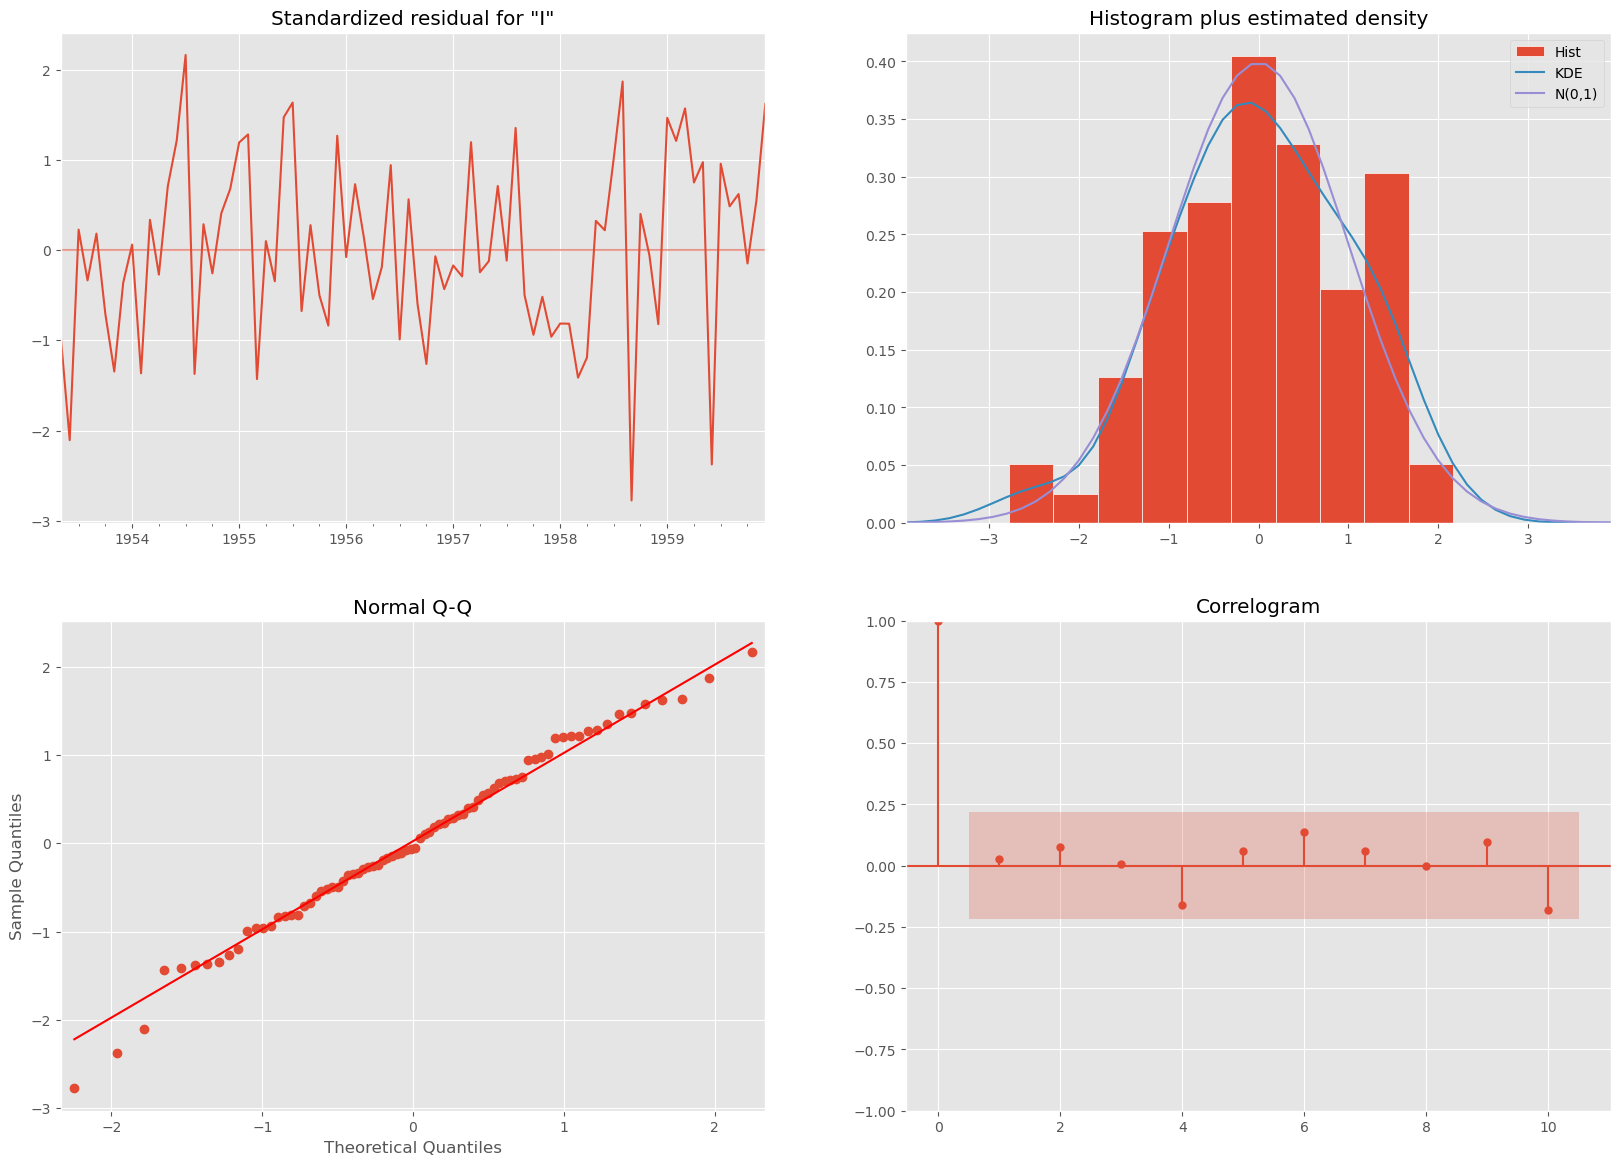

In [14]:
results.plot_diagnostics(figsize=(20, 14))
plt.show()

In the plots above, we can observe that the residuals are uncorrelated (bottom right plot) and do not exhibit any obvious seasonality (the top left plot). Also, the residuals and roughly normally distributed with zero mean (top right plot). The qq-plot on the bottom left shows that the ordered distribution of residuals (blue dots) roghly follows the linear trend of samples taken from a standard normal distribution with N(0, 1). Again, this is a strong indication that the residuals are normally distributed.

## Results
Now let's create some predictions. We will use three methods:

1) In sample prediction with 1-step ahead forecasting of the last year (1959). In this case the model is used to predict data that the model was built on. 1-step ahead forecasting implies that each forecasted point is used to predict the following one.

In [15]:
pred0 = results.get_prediction(start='1958-01-01', dynamic=False)
pred0_ci = pred0.conf_int()

2) In sample prediction with dynamic forecasting of the last year (1959). Again, the model is used to predict data that the model was built on.

In [16]:
pred1 = results.get_prediction(start='1958-01-01', dynamic=True)
pred1_ci = pred1.conf_int()

3) "True" forecasting of out of sample data. In this case the model is asked to predict data it has not seen before.

In [17]:
pred2 = results.get_forecast('1962-12-01')
pred2_ci = pred2.conf_int()
print(pred2.predicted_mean['1960-01-01':'1960-12-01'])

1960-01-01    419.493845
1960-02-01    397.831797
1960-03-01    460.857126
1960-04-01    449.449154
1960-05-01    474.553606
1960-06-01    537.847798
1960-07-01    614.883818
1960-08-01    628.208635
1960-09-01    519.334165
1960-10-01    462.252469
1960-11-01    412.161452
1960-12-01    452.661573
Freq: MS, Name: predicted_mean, dtype: float64


Let's plot all this

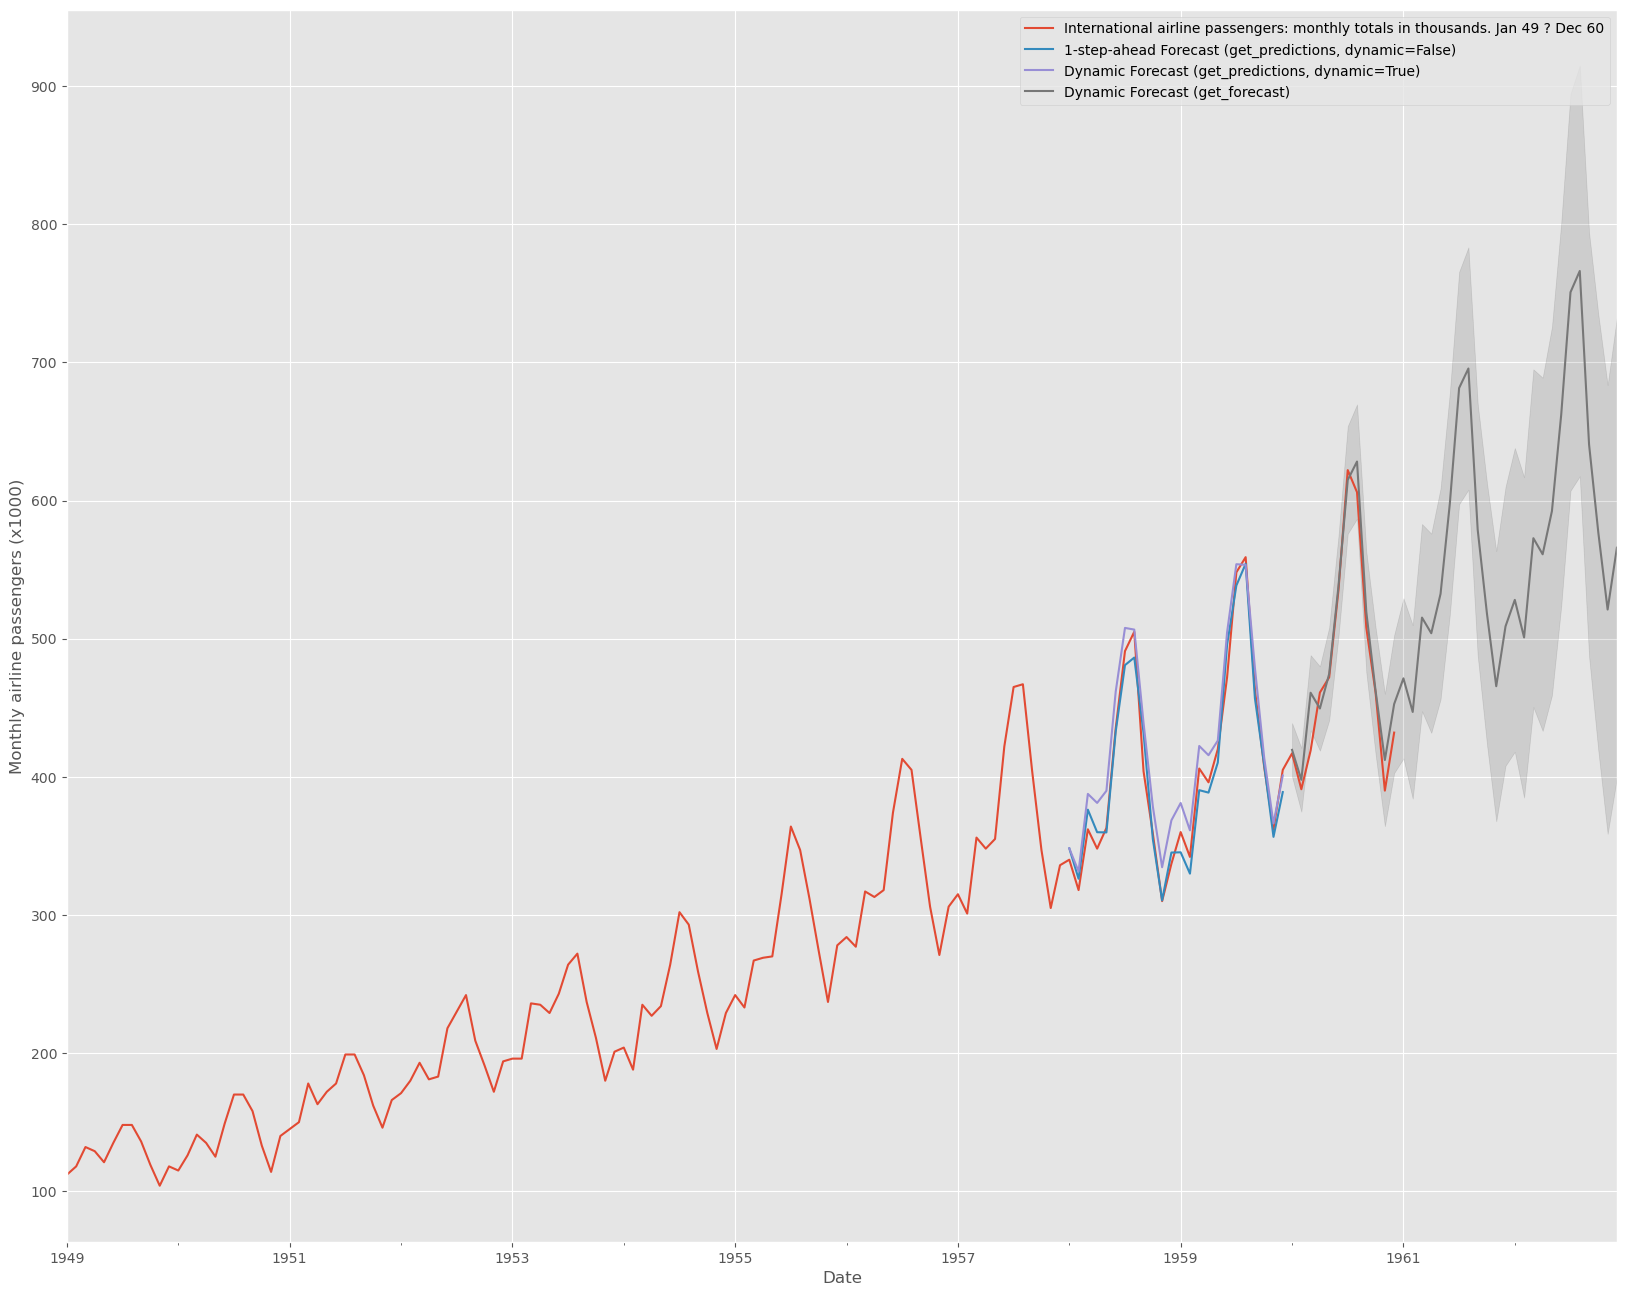

In [38]:
ax = data.plot(figsize=(20, 16))
pred0.predicted_mean.plot(ax=ax, label='1-step-ahead Forecast (get_predictions, dynamic=False)')
pred1.predicted_mean.plot(ax=ax, label='Dynamic Forecast (get_predictions, dynamic=True)')
pred2.predicted_mean.plot(ax=ax, label='Dynamic Forecast (get_forecast)')
ax.fill_between(pred2_ci.index, pred2_ci.iloc[:, 0], pred2_ci.iloc[:, 1], color='k', alpha=.1)
plt.ylabel('Monthly airline passengers (x1000)')
plt.xlabel('Date')
plt.legend()
plt.show()

Looking at the figure, the model seems to do a pretty good job at modeling the time series. The blue and purple lines are, as expected, very close to the red ground truth. What is more interesting is the gray line, the out of sample predinction. For such a simple time series, the ARIMA model is able to forecast the 1960 values accurately.

In order to quantify the accuracy of the prediction for 1960, we can compute metrics such as Mean Absolute Error, Mean Squared Error, or Root Mean Squared Error. These are all absolute metrics, are therefore scale-dependent. While they are useful, and widely used to compare different methods on a same dataset, here it would be more useful to express the error relatively to the magnitude of the time series we are trying to predict. One commonly-used percentage error measure is the Mean Absolute Percentage Error (MAPE). It has some drawbacks in special cases (notably, it can lead to division by zero) and improved measures have been proposed, see e.g. https://www.otexts.org/fpp/2/5 for a nice overview. However, for this example we'll stick with MAPE.

In [39]:
prediction = pred2.predicted_mean['1960-01-01':'1960-12-01'].values
# flatten nested list
truth = list(itertools.chain.from_iterable(test_data.values))
# Mean Absolute Percentage Error
MAPE = np.mean(np.abs((truth - prediction) / truth)) * 100

print('The Mean Absolute Percentage Error for the forecast of year 1960 is {:.2f}%'.format(MAPE))

The Mean Absolute Percentage Error for the forecast of year 1960 is 2.81%
